In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
import json
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer
from transformers import BertForSequenceClassification
import torch.nn as nn
import torch
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch import optim
from tqdm.auto import tqdm

In [6]:
def get_data(location):    
    with open(location, 'r') as f:
        train_file = json.load(f)
    train_data = {}
    train_data["emotions"] = []
    train_data["utterances"] = []
    train_data["labels"] = []
    for i in train_file:
        for j in range(len(i["utterances"])):
            if i["triggers"][j] is None:
                continue
            train_data["emotions"].append((i["emotions"][j], i["emotions"][-1]))
            train_data["utterances"].append(i["utterances"][j]+" [SEP] "+"[CLS] "+i["utterances"][-1])
            train_data["labels"].append(i["triggers"][j])
    return train_data

In [7]:
train_data = get_data("/kaggle/input/train/train_file.json")
val_data = get_data("/kaggle/input/validation/val_file.json")

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data["labels"])

    def __getitem__(self, index):
        curr_ut = self.tokenizer(self.data["utterances"][index], padding="max_length", max_length=512, truncation=True, return_tensors='pt')
        return (curr_ut, self.data["emotions"][index]), torch.tensor(self.data["labels"][index], dtype=torch.float32)

In [10]:
class Model(torch.nn.Module):
    def __init__(self, bert_model):
        super(Model, self).__init__()
        self.layer1 = bert_model
        self.layer2 = nn.Linear(782, 400)
        self.relu1 = nn.ReLU()
        self.layer3 = nn.Linear(400, 100)
        self.relu2 = nn.ReLU()
        self.layer4 = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, ids, mask, token_type_ids, emotion):
        _, out_1 = self.layer1(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
        out = torch.cat((out_1, emotion), dim=1)
        out = self.layer2(out)
        out = self.relu1(out)
        out = self.layer3(out)
        out = self.relu2(out)
        out = self.layer4(out)
        return self.sigmoid(out)

In [11]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
train_dataloader = DataLoader(dataset=CustomDataset(train_data, tokenizer), batch_size=1, num_workers=0, shuffle=True)
val_dataloader = DataLoader(dataset=CustomDataset(val_data, tokenizer), batch_size=1, num_workers=0, shuffle=True)

BERT_model = BertModel.from_pretrained('bert-base-uncased')
for para in BERT_model.parameters():
    para.requires_grad = True
model_1 = Model(BERT_model).to(device)
emoToInd = {"surprise": 0,
            "fear": 1,
            "sadness": 2,
            "disgust": 3,
            "anger": 4,
            "neutral": 5,
            "joy": 6}

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [12]:
def train(model, epochs, loss_fxn, optimizer, data_loader):
    for ep in tqdm(range(epochs)):
        model.train()
        no_step = 0
        loss_ep = 0
        for batch, (X, y) in enumerate(data_loader):
            y = y.to(device)

            ids = X[0]["input_ids"][0]
            att_mask = X[0]["attention_mask"][0]
            t_type = X[0]["token_type_ids"][0]
            emo1 = X[1][0][0]
            emo2 = X[1][1][0]
            oneHotEmo1 = [0.0]*7
            oneHotEmo2 = [0.0]*7
            oneHotEmo1[emoToInd[emo1]] = 1.0
            oneHotEmo2[emoToInd[emo2]] = 1.0
            oneHotEmo = oneHotEmo1+oneHotEmo2
            ids = ids.to(device)
            att_mask = att_mask.to(device)
            t_type = t_type.to(device)
            oneHotEmo = torch.tensor([oneHotEmo]).to(device)

            y_pred = model(ids, att_mask, t_type, oneHotEmo)


            loss = loss_fxn(y_pred[0], y)

            loss_ep += loss.item()
            no_step += 1

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
        torch.save({'epoch': ep,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, '/kaggle/working/model_ep_'+str(ep)+'.pth')
        print("Loss for epoch-"+str(ep)+": "+str(loss_ep/no_step))

In [15]:
def load_model(model, optim, file_name):
    checkpoint = torch.load(file_name, map_location=torch.device(device))
    model.load_state_dict(checkpoint["model_state_dict"])
    optim.load_state_dict(checkpoint["optimizer_state_dict"])
    return checkpoint["epoch"]

In [16]:
loss_fxn = nn.BCELoss()
opt = optim.Adam(model_1.parameters())

In [17]:
model_file = '/kaggle/input/model-3/model_ep_3.pth'
load_model(model_1, opt, model_file)

3

In [13]:
train(model_1, 5, loss_fxn, opt, train_dataloader)

  0%|          | 0/5 [00:00<?, ?it/s]

Loss for epoch-0: 0.44253018856566995
Loss for epoch-1: 0.43893858218052745
Loss for epoch-2: 0.4375931666803081
Loss for epoch-3: 0.43756123921584883
Loss for epoch-4: 0.4375838319685384


In [18]:
def evaluate(model, data_loader):
    model.eval()
    pred_lst = []
    true_lst = []
    with torch.inference_mode():
        for batch, (X, y) in enumerate(data_loader):

            ids = X[0]["input_ids"][0]
            att_mask = X[0]["attention_mask"][0]
            t_type = X[0]["token_type_ids"][0]
            emo1 = X[1][0][0]
            emo2 = X[1][1][0]
            oneHotEmo1 = [0.0]*7
            oneHotEmo2 = [0.0]*7
            oneHotEmo1[emoToInd[emo1]] = 1.0
            oneHotEmo2[emoToInd[emo2]] = 1.0
            oneHotEmo = oneHotEmo1+oneHotEmo2
            ids = ids.to(device)
            att_mask = att_mask.to(device)
            t_type = t_type.to(device)
            oneHotEmo = torch.tensor([oneHotEmo]).to(device)

            y_pred = model(ids, att_mask, t_type, oneHotEmo)
            y_pred = float(y_pred[0][0])
            y = int(y)
            if y_pred >= 0.5:
                y_pred = 1
            else:
                y_pred = 0
            pred_lst.append(y_pred)
            true_lst.append(y)
    return pred_lst, true_lst

In [22]:
pred_lst, true_lst = evaluate(model_1, val_dataloader)
f1_score(true_lst, pred_lst, average='macro')

0.4589117363224705

In [23]:
def plotloss(losses,name):
  epochs = range(1, len(losses) + 1)

  plt.plot(epochs, losses, marker='o', color='b', linestyle='-')


  plt.xlabel('Epoch Number')
  plt.ylabel(f'{name} Loss')
  plt.title(f'{name} Loss vs. Epoch Number')


  plt.grid(True)
  plt.tight_layout()
  plt.show()

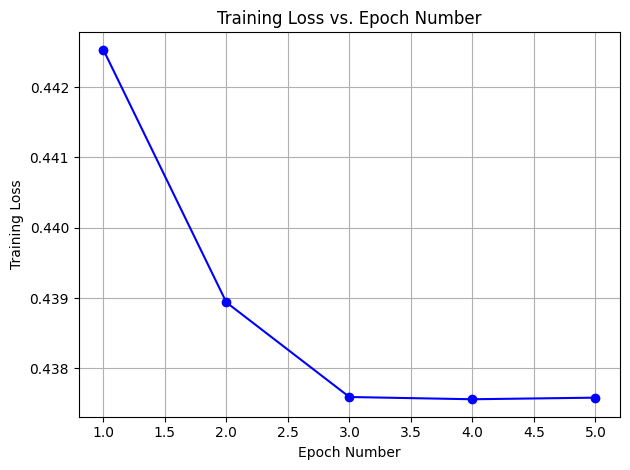

In [24]:
train_loss = [0.44253018856566995, 0.43893858218052745, 0.4375931666803081, 0.43756123921584883, 0.4375838319685384]
plotloss(train_loss, "Training")

In [29]:
def get_val(data_loader):
    val_loss = []
    for i in range(4):
        curr_loss = 0
        steps = 0
        BERT_model = BertModel.from_pretrained('bert-base-uncased')
        for para in BERT_model.parameters():
            para.requires_grad = True
        model = Model(BERT_model).to(device)
        loss_fxn = nn.BCELoss()
        opt = optim.Adam(model_1.parameters())
        model_file = '/kaggle/input/models/model_ep_'+str(i)+'.pth'
        load_model(model, opt, model_file)
        model.eval()    
        with torch.inference_mode():
            for batch, (X, y) in enumerate(data_loader):
                y = y.to(device)

                ids = X[0]["input_ids"][0]
                att_mask = X[0]["attention_mask"][0]
                t_type = X[0]["token_type_ids"][0]
                emo1 = X[1][0][0]
                emo2 = X[1][1][0]
                oneHotEmo1 = [0.0]*7
                oneHotEmo2 = [0.0]*7
                oneHotEmo1[emoToInd[emo1]] = 1.0
                oneHotEmo2[emoToInd[emo2]] = 1.0
                oneHotEmo = oneHotEmo1+oneHotEmo2
                ids = ids.to(device)
                att_mask = att_mask.to(device)
                t_type = t_type.to(device)
                oneHotEmo = torch.tensor([oneHotEmo]).to(device)

                y_pred = model(ids, att_mask, t_type, oneHotEmo)
                curr_loss += loss_fxn(y_pred[0], y)
                steps += 1
        val_loss.append(curr_loss/steps)
            
    return val_loss

In [30]:
val_loss = get_val(val_dataloader)

In [33]:
for i in range(len(val_loss)):
    val_loss[i] = float(val_loss[i])

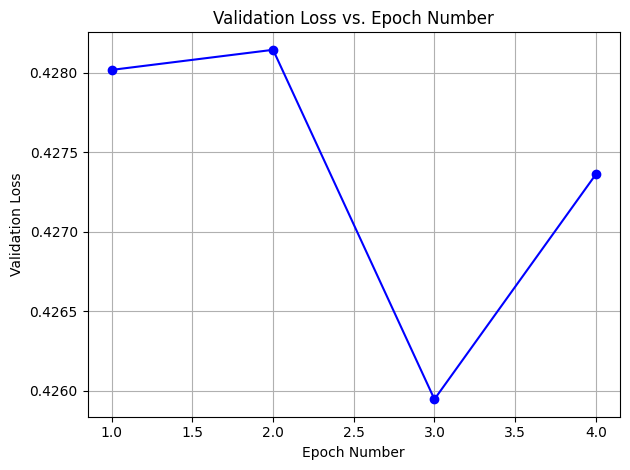

In [34]:
plotloss(val_loss, "Validation")